# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [25]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

# HYPERPARAMETERS
LEARNING_RATE = 1e-4
BATCH_SIZE = 64  # both for training and testing

# Load datasets
DATA_PATH = "./data"
NUM_WORKERS = 0
train_set = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [26]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

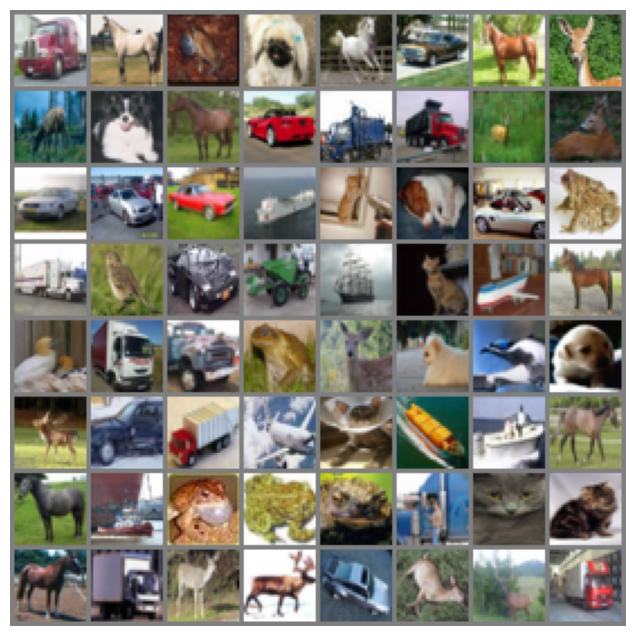

In [27]:
# Get random training images and show them.
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [28]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Defining some variables that might come in handy later
        n_out_features1 = 6
        n_out_features2 = 16
        n_out_features3 = 20
        pool_kernel_size = 2
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_out_features1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_out_features1),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel_size)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=n_out_features1, out_channels=n_out_features2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_out_features2),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel_size)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=n_out_features2, out_channels=n_out_features3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_out_features3),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel_size)
        )
        
        self.fc = nn.Sequential(
            # Found those 320, simply through errors. I know... very scientific
            nn.Linear(320, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 10),
            )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


model = CNN(n_classes)
DEVICE = "cude" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)  # use cuda or cpu
model.to(device)
print(model)

bla = torch.rand([1,3,32,32])
print(model(bla).size())

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=320, out_features=128, bias=True)
    (1): Linear(in_features=128, out_feat

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=0.9, weight_decay=1e-6)


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [30]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.01801158 -0.14754689 -0.28933132 -0.21289763 -0.27196214  0.0688241
   0.12293834  0.18598609  0.25461262  0.12521407]
 [-0.03599695  0.18269084 -0.218087   -0.13211335 -0.19149521 -0.06859046
   0.25764626  0.17133065  0.2880304   0.11860234]]
Output probabilities:
[[0.10151594 0.08602667 0.07465466 0.08058453 0.07596269 0.10680753
  0.11274657 0.12008386 0.12861416 0.11300345]
 [0.09147612 0.11383679 0.07624774 0.08309309 0.07830251 0.08854266
  0.12269739 0.1125509  0.12648267 0.10677002]]


In [34]:
NUM_EPOCHS = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        # Zeroing the computational graph
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = outputs.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")


Epoch: 0
Step 500     training accuracy: 0.40825
             test accuracy: 0.4143

Epoch: 1
Step 1000    training accuracy: 0.4181479357798165
             test accuracy: 0.4222
Step 1500    training accuracy: 0.42753125
             test accuracy: 0.4355

Epoch: 2
Step 2000    training accuracy: 0.43029673165137616
             test accuracy: 0.4406

Epoch: 3
Step 2500    training accuracy: 0.44754464285714285
             test accuracy: 0.4507
Step 3000    training accuracy: 0.44775
             test accuracy: 0.4574

Epoch: 4
Step 3500    training accuracy: 0.45913138440860213
             test accuracy: 0.4626

Epoch: 5
Step 4000    training accuracy: 0.46597222222222223
             test accuracy: 0.4697
Step 4500    training accuracy: 0.46928125
             test accuracy: 0.4738

Epoch: 6
Step 5000    training accuracy: 0.4811789772727273
             test accuracy: 0.4798

Epoch: 7
Step 5500    training accuracy: 0.4765625
             test accuracy: 0.4865
Step 6000    trai

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

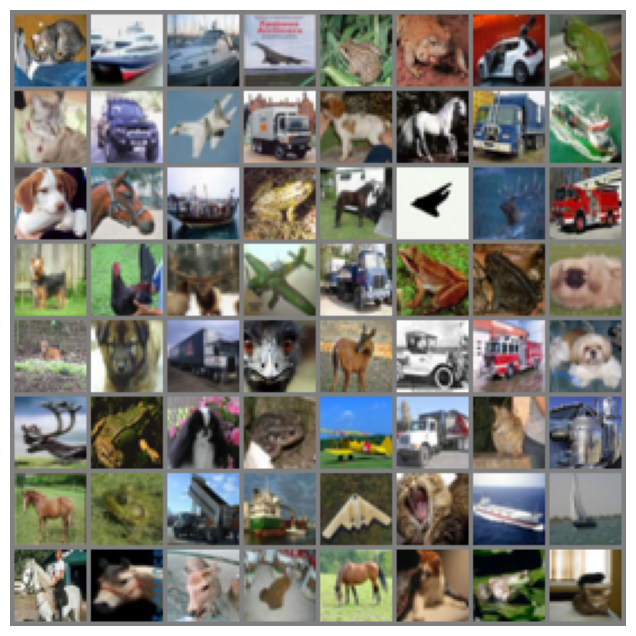

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane        ship     
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           dog     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse          dog     
    truck         truck    
    ship        airplane   
     dog           dog     
    horse          cat     
    ship          ship     
    frog          deer     
    horse         horse    
  airplane      airplane   
    deer          bird     
    truck      automobile  
     dog          deer     
    bird          frog     
    deer           cat     
  airplane        deer     
    truck      automobile  
    frog          frog     
    frog          frog     
     dog          deer     
    deer          bird     
     dog          fr

In [35]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [36]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [37]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.506


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


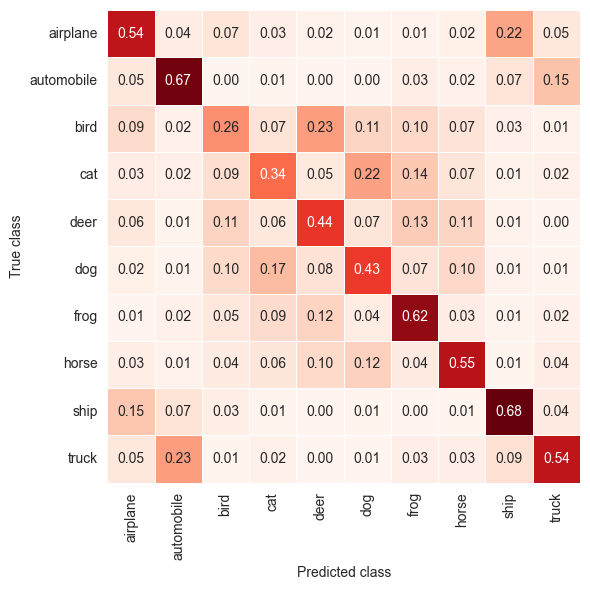

In [38]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

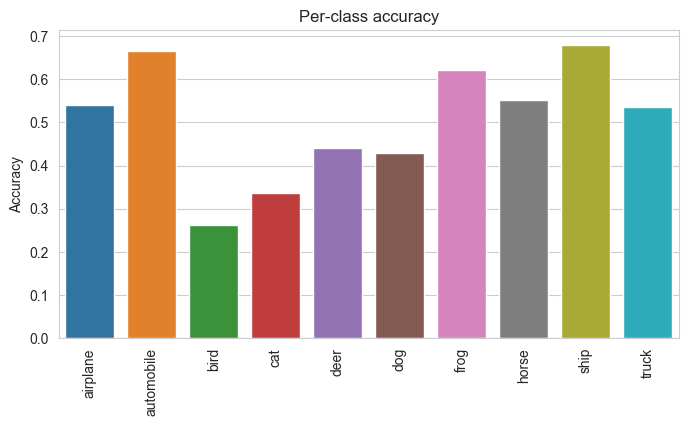

In [39]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

I tried varying the optimizer. Namely I started using SGD and went on to Adam later. For the final results I have used AdamW which has implemented weight decay in a different way. Then I tested different values of the learning rate. I opted for one that is relatively big, which Adam then decreases by the use of its own learning rate scheduler.

I was suprised to see that a kernel size of 5 didn't contribute to the test accuracy, so I ended using only 3 convolutional layers, each with padding and a 3x3 convolution.

## HyperParams and loading data

In [69]:
# HYPERPARAMETERS
LEARNING_RATE = 1e-2
BATCH_SIZE = 64  # both for training and testing

# Load datasets
DATA_PATH = "./data"
MODEL_SAVE_PATH = "./model/myNet.pth"
NUM_WORKERS = 0
train_set = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


## Network

In [66]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Defining some variables that might come in handy later
        n_out_features1 = 6
        n_out_features2 = 16
        n_out_features3 = 20
        pool_kernel_size = 2
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_out_features1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_out_features1),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel_size)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=n_out_features1, out_channels=n_out_features2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_out_features2),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel_size)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=n_out_features2, out_channels=n_out_features3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_out_features3),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel_size)
        )
        
        self.fc = nn.Sequential(
            # Found those 320, simply through errors. I know... very scientific
            nn.Linear(320, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 10),
            )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


model = CNN(n_classes)
DEVICE = "cude" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)  # use cuda or cpu
model.to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=320, out_features=128, bias=True)
    (1): Linear(in_features=128, out_feat

## Loss function and optimizer

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)


## Training

In [71]:
NUM_EPOCHS = 15
validation_every_steps = 500

step = 0
model.train()

# For updating the network
best_val_acc = 0
best_epoch = 0

train_accuracies = []
valid_accuracies = []
        
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        # Zeroing the computational graph
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = outputs.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    val_acc = accuracy(targets, predictions) * len(inputs)
                    valid_accuracies_batches.append(val_acc)
                    if best_val_acc < val_acc:
                        torch.save(model.state_dict(), MODEL_SAVE_PATH)
                        best_val_acc = val_acc
                        best_epoch = epoch + 1

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")


Epoch: 1
Step 500     training accuracy: 0.6059375
             test accuracy: 0.5974

Epoch: 2
Step 1000    training accuracy: 0.6158256880733946
             test accuracy: 0.6278
Step 1500    training accuracy: 0.624875
             test accuracy: 0.5991

Epoch: 3
Step 2000    training accuracy: 0.6334934059633027
             test accuracy: 0.639

Epoch: 4
Step 2500    training accuracy: 0.6506696428571429
             test accuracy: 0.6124
Step 3000    training accuracy: 0.64090625
             test accuracy: 0.604

Epoch: 5
Step 3500    training accuracy: 0.6499915994623656
             test accuracy: 0.621

Epoch: 6
Step 4000    training accuracy: 0.6590277777777778
             test accuracy: 0.628
Step 4500    training accuracy: 0.6521875
             test accuracy: 0.6299

Epoch: 7
Step 5000    training accuracy: 0.6660409902597403
             test accuracy: 0.5976

Epoch: 8
Step 5500    training accuracy: 0.6778846153846154
             test accuracy: 0.6434
Step 6000    t

## Learning curves

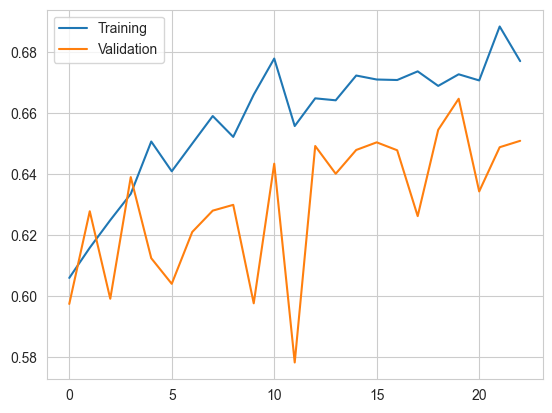

In [72]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label="Training")
plt.plot(valid_accuracies, label="Validation")
plt.legend()
plt.show()

## Reload models

In [73]:
model = CNN(n_classes)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)  # use cuda or cpu
model.to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH)) 

<All keys matched successfully>

## Testing

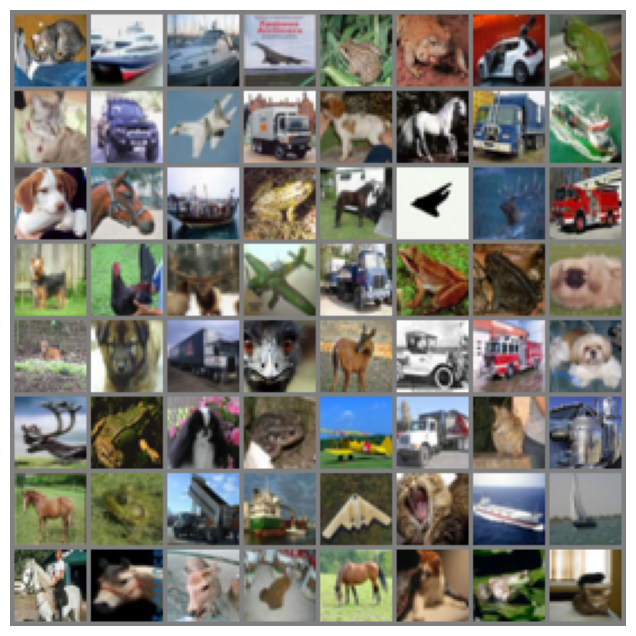

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog          deer     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse          cat     
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck      automobile  
     dog          deer     
    bird          deer     
    deer           cat     
  airplane        deer     
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           d

In [74]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")

In [75]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


In [76]:
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"Was achieved by the model trained at epoch: {best_epoch}")

Test accuracy: 0.655
Was achieved by the model trained at epoch: 13


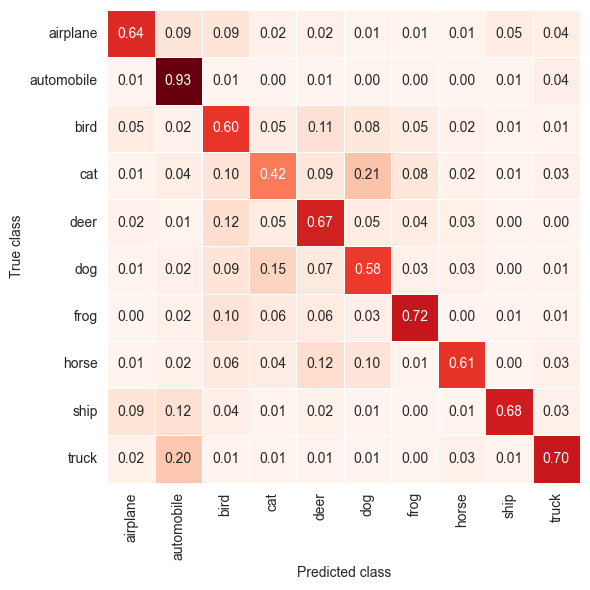

In [77]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

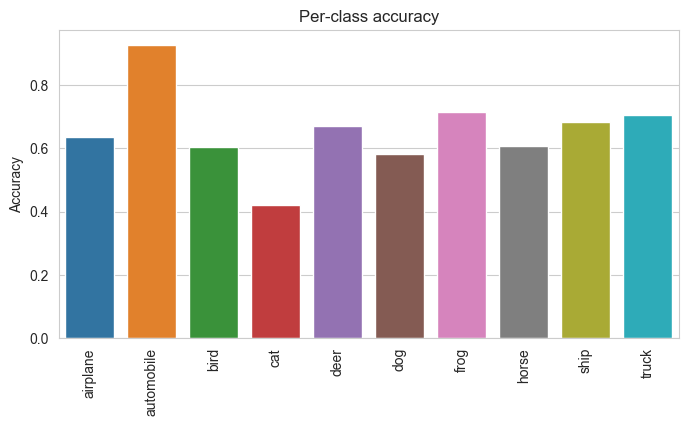

In [78]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





*I picked the following exercise*

**I explained gradient descent when *C* is a function of two variables, and when it's a function of more than two variables. What happens when *C* is a function of just one variable? Can you provide a geometric interpretation of what gradient descent is doing in the one-dimensional case?**

The Gradient descent algorithm in its simplicity takes a step (of the size $\eta$) in the negative direction of the gradient $- \nabla C$. The algorithm aims at converging towards some minima, however it will often end up in a local minima, hence the implementation of more sophisticated methods.

In the one-dimensional case the gradient $\frac{\partial C}{\partial x}$ simply tells us whether we should move "left" or "right" (considering a usual cartesian coordinate system with $C(x)$ along the vertical axes). Given the direction the algorithm will then take a step in the size of the learning rate $\eta$. Like climbing down a narrow valley on a pogo stick.